# Implementez un modèle de scoring

## Import des libraries

## Rapple de la mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

In [2]:
import time
import shap
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, learning_curve, cross_validate, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression  
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from lightgbm import LGBMClassifier
from IPython.display import display, HTML
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from contextlib import contextmanager


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def display_info(title = "",titleTag="h2",tag="div",pTag="p",message="Params allowed: title,tag,message,color",bgd="#96d6ee", styleClass="alert alert-block alert-info", fontsize="" , color="black"):
    if (title!=""):
        display(HTML(f"""<{titleTag} style='color:{color};font-size:{fontsize}'>{title}</{titleTag}>"""))
    else:
        display(HTML(f"""
                     <{tag} style='background:{bgd}; padding-top:5px; padding-bottom:5px; padding-left:10px;' class='{styleClass}'><{pTag} style='color:{color}; font-size:{fontsize}'>{message}</{pTag}></{tag}>
"""))

In [4]:
app_train = pd.read_csv('../datas/application_train.csv')

In [5]:
@contextmanager
def timer(title):
    t0=time.time()
    yield
    print("{} - terminé en {:.000f}s".format(title, time.time()-t0))

In [6]:
display_info(message="On traite les valeurs impossible ici")
def manage_imp_value(df):
    df.loc[df['CNT_CHILDREN'] > 7 , 'CNT_CHILDREN'] = np.nan
    df['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)
    return df

In [7]:
def featureImportCalc(X,y, preprocessor):
    print(f"fetImport X shape {X.shape} et y shape {y.shape}")
    model=lgb.LGBMClassifier()
    model.fit(X,y)

    importances = model.feature_importances_
    indices = importances.argsort()
    feature_names = preprocessor.get_feature_names_out()
    feature_names_clean = [name.split('__')[-1] for name in feature_names]  # Supprimer les préfixes


    feature_importances = pd.DataFrame({
        "feature": feature_names_clean,
        "Importance" : importances,
    })
    return importances, indices, feature_names_clean, feature_importances 

In [8]:

def preprocessing():
    # display_info(message="On sépare nos variable numérique de nos variable qualitative")
    numerical_features = make_column_selector(dtype_include=np.number)
    categorical_features = make_column_selector(dtype_exclude=np.number)
    # display_info(message=f"""On obtient donc {numerical_features.shape[0]} numerical_features \n
    #               et {categorical_features.shape[1]} categorical_features""")

    # display_info(message="On creer un pipeline pour chaque type de variables")
    numerical_pipeline = Pipeline([
        ("imputer",SimpleImputer(strategy="mean")),
        ("scaler",StandardScaler())
        ])
    # display_info(message=f"""Pour les feature numerique numerical_pipeline =  {numerical_pipeline}""")


    categorical_pipeline = Pipeline([
        ("imputer",SimpleImputer(strategy='most_frequent')),
        ("encoder",OneHotEncoder(handle_unknown="ignore"))
        ])
    # display_info(message=f"""Pour les feature categoriels categorical_pipeline =  {categorical_pipeline}""")

    # categorical_pipeline = Pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())


    preprocessor =make_column_transformer(
        (numerical_pipeline,numerical_features),
        (categorical_pipeline, categorical_features)
        )
    return preprocessor

In [9]:
def split_df(df):
    X_train,X_val= train_test_split(df,test_size=0.2, stratify=df['TARGET'], random_state=42)
    
    X=X_train.drop('TARGET', axis=1)
    y=X_train['TARGET']
    X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
    return X_train, X_test, y_train, y_test, X_val
X_train, X_test, y_train, y_test, X_val= split_df(app_train)


In [10]:
def new_features(df):
    df['DEBT_RATE']= df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'] # Taux d'endettement
    df['KEEP_FOR_LIVING']= ((df['AMT_INCOME_TOTAL'] - df['AMT_ANNUITY'])/12)/df['CNT_FAM_MEMBERS'] #Reste a vivre mensuel
    df['INCOME_PER_PERSON']=df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'] # Somme par personne dans le foyer
    return df

In [11]:
def feature_importanceGraph(importances, indices, name, importances_lgbm_reordered, feature_names):
    n_features = len(importances_lgbm_reordered)
    fig_height = n_features * 0.5
    plt.figure(figsize=(10, fig_height))
    plt.barh(range(len(indices[-n_features:])), importances[indices[-n_features:]], align='center')
    plt.yticks(range(len(indices[-n_features:])), [feature_names[i] for i in indices[-n_features:]], fontsize=8)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'Top {n_features} Feature Importances with {name}')
    plt.show()

In [12]:
def getfeatureImportances(df,y=None,displayGraph=True):
    preprocessor = preprocessing()

    # variances = X_train.select_dtypes(include=[np.number]).var()
    if y is None:
        y_train = y_train
    else:
        y_train=y
    df_transformed = preprocessor.fit_transform(df)
    
    feature_names = preprocessor.get_feature_names_out()
    feature_names = [name.split('__')[-1] for name in feature_names]

    X_transformed = pd.DataFrame(df_transformed, columns=feature_names)
    
    variances = X_transformed.var()
    
    importances, indices, feature_names, _ = featureImportCalc(df_transformed, y_train, preprocessor)

    name = 'LightGBM'
    importances_df = pd.DataFrame({
        'Features': feature_names,
        f'{name} Importances':importances,
        f'Variance':variances.values
    })

    # Fonction pour réorganiser l'ordre des colonnes en fonction du tri
    def reorder_columns(df, primary_model):
        cols = ['Features', primary_model] + [col for col in df.columns if col != 'Features' and col != primary_model]
        return df[cols]

    display_info(message=f"=== Feature importance classé par ordre décroissant sur {name} ===")
    importances_dfLGBM = importances_df.sort_values(by=f'{name} Importances', ascending=False)
    importances_lgbm_reordered = reorder_columns(importances_dfLGBM, f'{name} Importances')
    display(importances_lgbm_reordered)

    if displayGraph:
        feature_importanceGraph(importances,indices, name,importances_lgbm_reordered,feature_names)

    return X_transformed, importances_lgbm_reordered


In [13]:
Fs_treshold = 65
def feature_selection(importances_lgbm_reordered, df ):
    # importances_lgbm_reordered = importances_lgbm_reordered
    treshold = Fs_treshold # cumulative importance max
    varianceTreshold = 1 # cumulative importance max
    df = df.sort_values(by='LightGBM Importances',ascending=False)
    df['Cumulative Importance %'] = ((df['LightGBM Importances']*100)/ df['LightGBM Importances'].sum()).cumsum()

    df = df[(df['Cumulative Importance %']<=treshold) & (df['Variance']>int(varianceTreshold))]
    return df, importances_lgbm_reordered

In [14]:
def feature_importance_Choice(df,df_to_treat):

    display_info(message=f"On selectionne les feature qui font partie des {Fs_treshold}% les plus représentées de notre dataset et une variance  > 1")
    display(df['Features'].count())
    display(df)
    preprocessor= preprocessing() ## Recuperation du pipeline de preprocessing

    df_with_feature_selected = df_to_treat[df['Features']] ## selection dans Xtrain des feature retenu 
    df_with_feature_selected = preprocessor.fit_transform(df_with_feature_selected) ## traitement des données avec les preprocessing
    feature_names = preprocessor.get_feature_names_out() ## on recupère le nom des features 
    feature_names = [name.split('__')[-1] for name in feature_names]
    df_with_feature_selected = pd.DataFrame(df_with_feature_selected,columns=feature_names) ## on reafecte le nom à chaque feature
    display_info(message="DataFrame avec les feature selectionnées en fonction de leurs importances")
    display(df_with_feature_selected)
    # display_info(message="Regardons la correlation de pearson pour les features selectionnées avant de créer nos polynomiales feature")

    correlation_matrix = df_with_feature_selected.corr(method='pearson')

    matrix = np.triu(correlation_matrix)
    plt.figure(figsize=(16,8))
    sns.heatmap(correlation_matrix, annot=True, mask=matrix, fmt=".2f")

    return df_with_feature_selected

fetImport X shape (196806, 245) et y shape (196806,)
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11802
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 233
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480


Features  LightGBM Importances  Variance
28               EXT_SOURCE_1                   219  1.000005
30               EXT_SOURCE_3                   217  1.000005
29               EXT_SOURCE_2                   188  1.000005
7                  DAYS_BIRTH                   184  1.000005
3                  AMT_CREDIT                   145  1.000005
..                        ...                   ...       ...
82            FLAG_DOCUMENT_5                     0  1.000005
83            FLAG_DOCUMENT_6                     0  1.000005
153  OCCUPATION_TYPE_IT staff                     0  0.001689
84            FLAG_DOCUMENT_7                     0  1.000005
244   EMERGENCYSTATE_MODE_Yes                     0  0.007358

[245 rows x 3 columns]

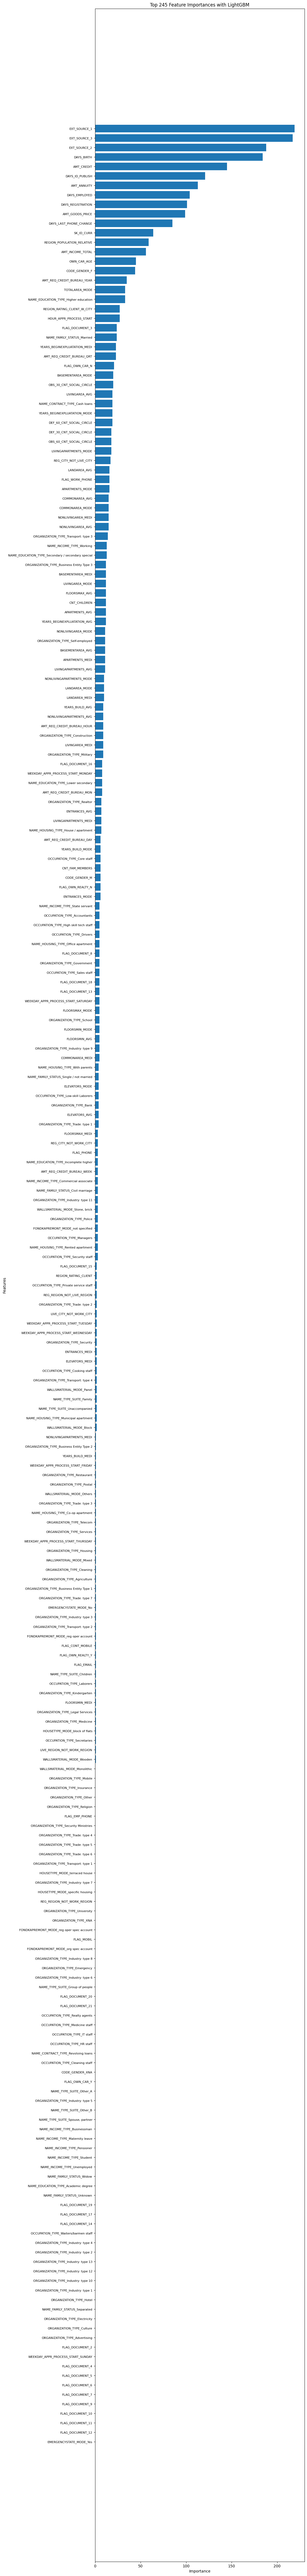

np.int64(17)

Features  LightGBM Importances  Variance  \
28                 EXT_SOURCE_1                   219  1.000005   
30                 EXT_SOURCE_3                   217  1.000005   
29                 EXT_SOURCE_2                   188  1.000005   
7                    DAYS_BIRTH                   184  1.000005   
3                    AMT_CREDIT                   145  1.000005   
10              DAYS_ID_PUBLISH                   121  1.000005   
4                   AMT_ANNUITY                   113  1.000005   
8                 DAYS_EMPLOYED                   104  1.000005   
9             DAYS_REGISTRATION                   101  1.000005   
5               AMT_GOODS_PRICE                    99  1.000005   
78       DAYS_LAST_PHONE_CHANGE                    85  1.000005   
0                    SK_ID_CURR                    64  1.000005   
6    REGION_POPULATION_RELATIVE                    59  1.000005   
2              AMT_INCOME_TOTAL                    56  1.000005   
11                  OWN_CAR_AGE                    45  1.000005   
104  AMT_REQ_CREDIT_BUREAU_YEAR                    35  1.000005   
73               TOTALAREA_MODE                    33  1.000005   

     Cumulative Importance %  
28                  7.300000  
30                 14.533333  
29                 20.800000  
7                  26.933333  
3                  31.766667  
10                 35.800000  
4                  39.566667  
8                  43.033333  
9                  46.400000  
5                  49.700000  
78                 52.533333  
0                  54.666667  
6                  56.633333  
2                  58.500000  
11                 60.000000  
104                62.633333  
73                 64.833333

EXT_SOURCE_1  EXT_SOURCE_3  EXT_SOURCE_2  DAYS_BIRTH  AMT_CREDIT  \
0       1.589111e-15 -6.372508e-16     -0.646817   -0.841308    0.519417   
1      -2.934472e-01 -1.647862e+00      0.639618    0.463433    0.332453   
2      -1.677312e-01  5.560069e-03      0.667931   -0.461456   -0.109410   
3      -3.263536e+00 -1.559498e+00     -0.218215   -0.000959    0.585756   
4       1.589111e-15  5.249847e-01     -0.081859   -0.458935    2.791667   
...              ...           ...           ...         ...         ...   
196801 -6.184661e-01 -6.978752e-01      0.001869    1.752594   -0.817397   
196802  1.589111e-15 -7.273320e-01      0.423767   -0.308415   -0.929077   
196803  1.589111e-15 -6.372508e-16     -1.304998    0.948214   -0.193774   
196804  1.589111e-15  2.833257e-01      1.348495   -0.514607   -0.873237   
196805  2.306745e+00  5.743760e-01     -2.451922   -1.323570   -0.370675   

        DAYS_ID_PUBLISH  AMT_ANNUITY  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0             -0.157544    -0.230262      -0.463846          -1.670596   
1             -0.789022     0.831998      -0.472476          -0.174393   
2              0.938921    -0.625046      -0.486959           1.159882   
3              0.477915     0.909157      -0.453125           1.293735   
4              0.950197     1.613199      -0.459594          -1.365740   
...                 ...          ...            ...                ...   
196801         1.295786    -0.937712      -0.455322          -0.226289   
196802         1.368088    -1.076228      -0.491933          -1.543265   
196803        -0.408941    -0.277363      -0.477648           0.521245   
196804         0.783041    -1.015182      -0.521175           1.026029   
196805        -1.541225     0.449609       2.137115           0.738756   

        AMT_GOODS_PRICE  DAYS_LAST_PHONE_CHANGE  SK_ID_CURR  \
0              0.368835               -1.207443    0.248182   
1              0.381012               -0.262937    0.576376   
2             -0.203478                1.164101   -1.103092   
3              0.368835               -0.811984    0.940870   
4              2.195365               -0.220610   -0.919322   
...                 ...                     ...         ...   
196801        -0.727083               -0.194004   -1.569747   
196802        -0.848851                0.118009    1.302184   
196803        -0.240008               -2.478475    0.843397   
196804        -0.787967                0.242573    1.157351   
196805        -0.240008               -0.247216    1.702463   

        REGION_POPULATION_RELATIVE  AMT_INCOME_TOTAL   OWN_CAR_AGE  \
0                        -0.745589         -0.511775 -2.567001e-16   
1                         0.271182          0.931987 -2.567001e-16   
2                         0.271182         -0.511775 -2.567001e-16   
3                         1.080170          1.138239 -1.162521e+00   
4                         0.311262          0.313232 -2.567001e-16   
...                            ...               ...           ...   
196801                   -0.812582          0.519483 -2.567001e-16   
196802                   -0.810629          0.106980  7.161004e-01   
196803                    0.715756          0.106980 -7.289928e-01   
196804                   -0.885292         -0.305524 -1.451539e+00   
196805                    0.311262         -0.718027 -1.307030e+00   

        AMT_REQ_CREDIT_BUREAU_YEAR  TOTALAREA_MODE  
0                     1.275984e-16    2.059296e+00  
1                     1.781462e+00   -6.192386e-01  
2                    -1.091798e+00   -1.807983e-16  
3                     4.080070e+00   -1.807983e-16  
4                    -5.171464e-01   -1.807983e-16  
...                            ...             ...  
196801               -1.091798e+00    5.560624e-02  
196802                1.781462e+00   -1.807983e-16  
196803                1.275984e-16   -1.807983e-16  
196804               -1.091798e+00    9.402002e-01  
196805                5.7

EXT_SOURCE_1  EXT_SOURCE_3  EXT_SOURCE_2  DAYS_BIRTH  AMT_CREDIT  \
0       1.589111e-15 -6.372508e-16     -0.646817   -0.841308    0.519417   
1      -2.934472e-01 -1.647862e+00      0.639618    0.463433    0.332453   
2      -1.677312e-01  5.560069e-03      0.667931   -0.461456   -0.109410   
3      -3.263536e+00 -1.559498e+00     -0.218215   -0.000959    0.585756   
4       1.589111e-15  5.249847e-01     -0.081859   -0.458935    2.791667   
...              ...           ...           ...         ...         ...   
196801 -6.184661e-01 -6.978752e-01      0.001869    1.752594   -0.817397   
196802  1.589111e-15 -7.273320e-01      0.423767   -0.308415   -0.929077   
196803  1.589111e-15 -6.372508e-16     -1.304998    0.948214   -0.193774   
196804  1.589111e-15  2.833257e-01      1.348495   -0.514607   -0.873237   
196805  2.306745e+00  5.743760e-01     -2.451922   -1.323570   -0.370675   

        DAYS_ID_PUBLISH  AMT_ANNUITY  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0             -0.157544    -0.230262      -0.463846          -1.670596   
1             -0.789022     0.831998      -0.472476          -0.174393   
2              0.938921    -0.625046      -0.486959           1.159882   
3              0.477915     0.909157      -0.453125           1.293735   
4              0.950197     1.613199      -0.459594          -1.365740   
...                 ...          ...            ...                ...   
196801         1.295786    -0.937712      -0.455322          -0.226289   
196802         1.368088    -1.076228      -0.491933          -1.543265   
196803        -0.408941    -0.277363      -0.477648           0.521245   
196804         0.783041    -1.015182      -0.521175           1.026029   
196805        -1.541225     0.449609       2.137115           0.738756   

        AMT_GOODS_PRICE  DAYS_LAST_PHONE_CHANGE  SK_ID_CURR  \
0              0.368835               -1.207443    0.248182   
1              0.381012               -0.262937    0.576376   
2             -0.203478                1.164101   -1.103092   
3              0.368835               -0.811984    0.940870   
4              2.195365               -0.220610   -0.919322   
...                 ...                     ...         ...   
196801        -0.727083               -0.194004   -1.569747   
196802        -0.848851                0.118009    1.302184   
196803        -0.240008               -2.478475    0.843397   
196804        -0.787967                0.242573    1.157351   
196805        -0.240008               -0.247216    1.702463   

        REGION_POPULATION_RELATIVE  AMT_INCOME_TOTAL   OWN_CAR_AGE  \
0                        -0.745589         -0.511775 -2.567001e-16   
1                         0.271182          0.931987 -2.567001e-16   
2                         0.271182         -0.511775 -2.567001e-16   
3                         1.080170          1.138239 -1.162521e+00   
4                         0.311262          0.313232 -2.567001e-16   
...                            ...               ...           ...   
196801                   -0.812582          0.519483 -2.567001e-16   
196802                   -0.810629          0.106980  7.161004e-01   
196803                    0.715756          0.106980 -7.289928e-01   
196804                   -0.885292         -0.305524 -1.451539e+00   
196805                    0.311262         -0.718027 -1.307030e+00   

        AMT_REQ_CREDIT_BUREAU_YEAR  TOTALAREA_MODE  
0                     1.275984e-16    2.059296e+00  
1                     1.781462e+00   -6.192386e-01  
2                    -1.091798e+00   -1.807983e-16  
3                     4.080070e+00   -1.807983e-16  
4                    -5.171464e-01   -1.807983e-16  
...                            ...             ...  
196801               -1.091798e+00    5.560624e-02  
196802                1.781462e+00   -1.807983e-16  
196803                1.275984e-16   -1.807983e-16  
196804               -1.091798e+00    9.402002e-01  
196805                5.7

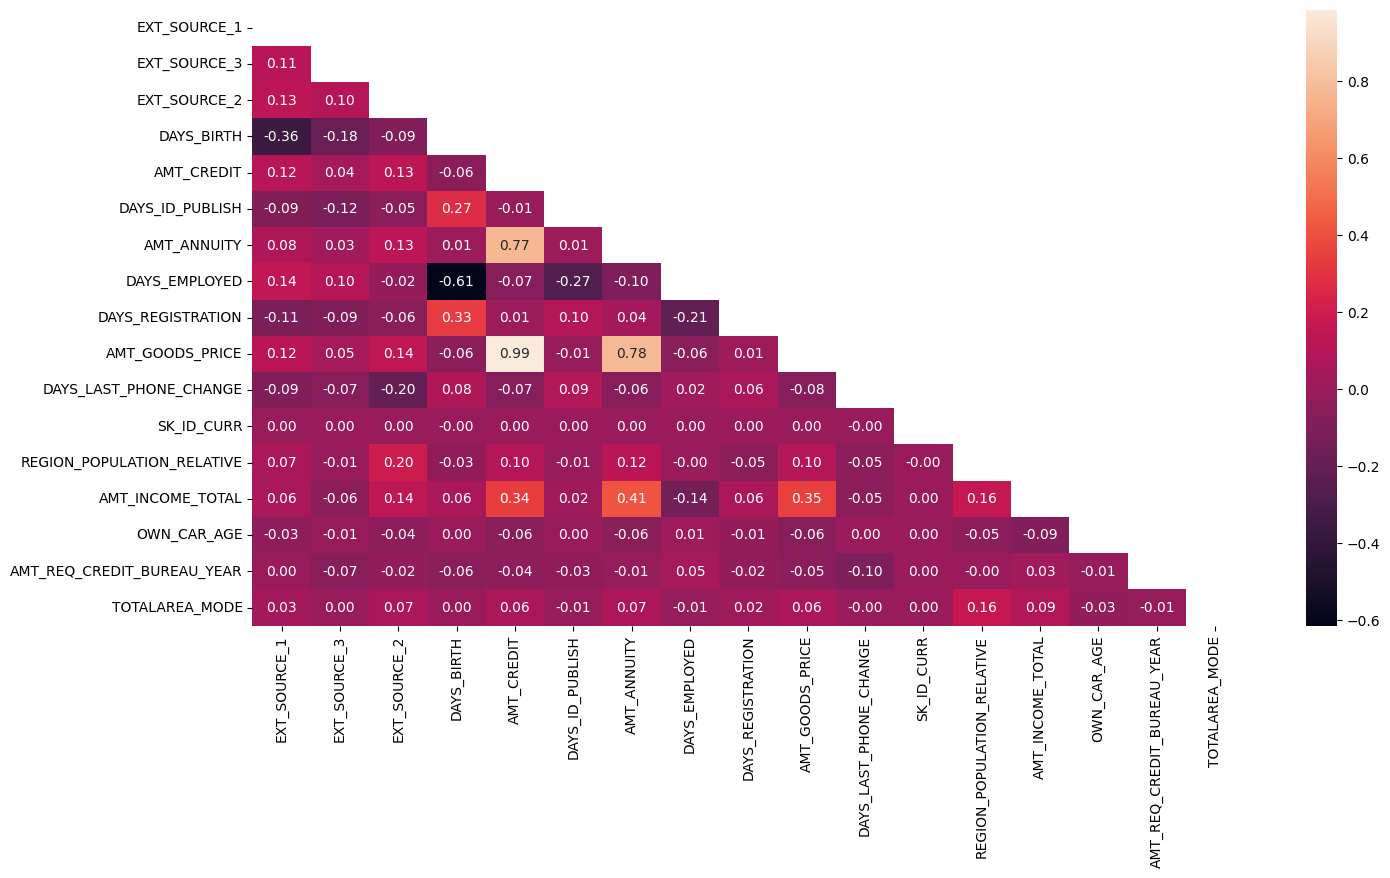

In [15]:
display_info(title="Feature selection", color='red', fontsize='30px')

display_info(title="Feature importance sur X_train seul", color="DarkRed")
def feat_importance(df_input,y=None):
    if y is None:
        pass
    else:
        y_train=y
    importances_lgbm_reordered, df_transformed = getfeatureImportances(df_input,y_train)
    df, importances_lgbm_reordered= feature_selection(importances_lgbm_reordered, df_transformed)
    df_with_feature_selected= feature_importance_Choice(df, df_input)
    return df_with_feature_selected
feat_importance(X_train, y=y_train)

fetImport X shape (196806, 248) et y shape (196806,)
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12559
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480


Features  LightGBM Importances  Variance
28                          EXT_SOURCE_1                   219  1.000005
30                          EXT_SOURCE_3                   206  1.000005
29                          EXT_SOURCE_2                   193  1.000005
7                             DAYS_BIRTH                   160  1.000005
3                             AMT_CREDIT                   138  1.000005
..                                   ...                   ...       ...
154             OCCUPATION_TYPE_HR staff                     0  0.001816
141           NAME_FAMILY_STATUS_Unknown                     0  0.000010
132  NAME_EDUCATION_TYPE_Academic degree                     0  0.000488
130          NAME_INCOME_TYPE_Unemployed                     0  0.000061
247              EMERGENCYSTATE_MODE_Yes                     0  0.007358

[248 rows x 3 columns]

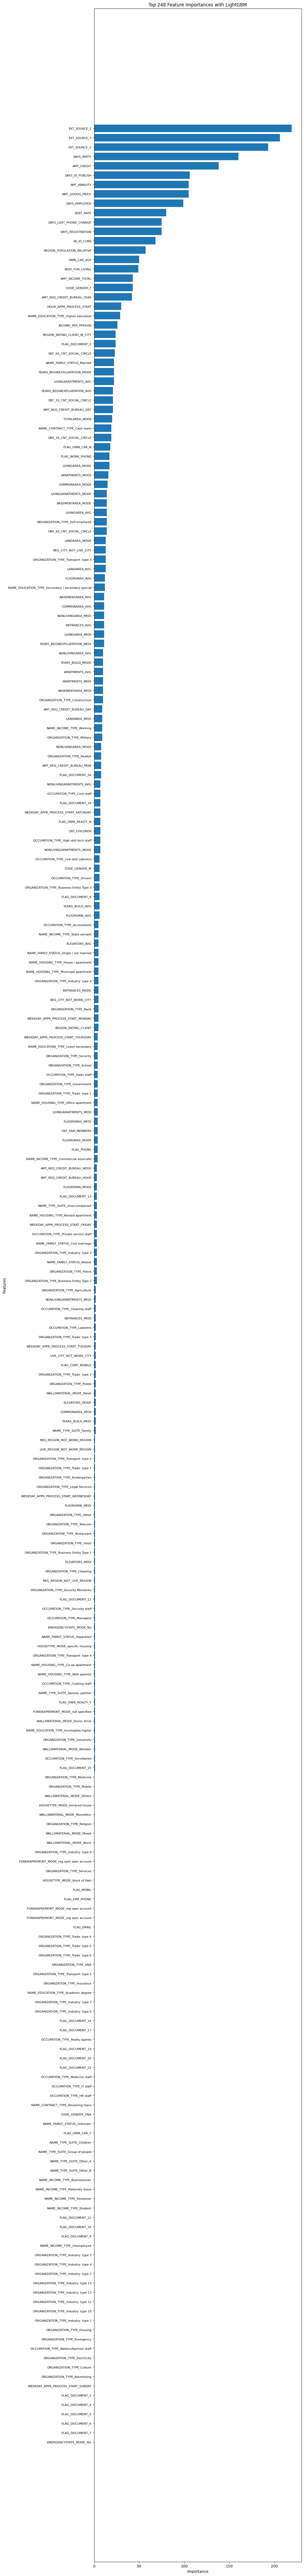

np.int64(19)

Features  LightGBM Importances  Variance  \
28                 EXT_SOURCE_1                   219  1.000005   
30                 EXT_SOURCE_3                   206  1.000005   
29                 EXT_SOURCE_2                   193  1.000005   
7                    DAYS_BIRTH                   160  1.000005   
3                    AMT_CREDIT                   138  1.000005   
10              DAYS_ID_PUBLISH                   106  1.000005   
4                   AMT_ANNUITY                   105  1.000005   
5               AMT_GOODS_PRICE                   105  1.000005   
8                 DAYS_EMPLOYED                    99  1.000005   
105                   DEBT_RATE                    80  1.000005   
78       DAYS_LAST_PHONE_CHANGE                    75  1.000005   
9             DAYS_REGISTRATION                    75  1.000005   
0                    SK_ID_CURR                    68  1.000005   
6    REGION_POPULATION_RELATIVE                    57  1.000005   
11                  OWN_CAR_AGE                    50  1.000005   
106             KEEP_FOR_LIVING                    49  1.000005   
2              AMT_INCOME_TOTAL                    43  1.000005   
104  AMT_REQ_CREDIT_BUREAU_YEAR                    42  1.000005   
21      HOUR_APPR_PROCESS_START                    30  1.000005   

     Cumulative Importance %  
28                  7.300000  
30                 14.166667  
29                 20.600000  
7                  25.933333  
3                  30.533333  
10                 34.066667  
4                  37.566667  
5                  41.066667  
8                  44.366667  
105                47.033333  
78                 49.533333  
9                  52.033333  
0                  54.300000  
6                  56.200000  
11                 57.866667  
106                59.500000  
2                  60.933333  
104                63.766667  
21                 64.766667

EXT_SOURCE_1  EXT_SOURCE_3  EXT_SOURCE_2  DAYS_BIRTH  AMT_CREDIT  \
0       1.589111e-15 -6.372508e-16     -0.646817   -0.841308    0.519417   
1      -2.934472e-01 -1.647862e+00      0.639618    0.463433    0.332453   
2      -1.677312e-01  5.560069e-03      0.667931   -0.461456   -0.109410   
3      -3.263536e+00 -1.559498e+00     -0.218215   -0.000959    0.585756   
4       1.589111e-15  5.249847e-01     -0.081859   -0.458935    2.791667   
...              ...           ...           ...         ...         ...   
196801 -6.184661e-01 -6.978752e-01      0.001869    1.752594   -0.817397   
196802  1.589111e-15 -7.273320e-01      0.423767   -0.308415   -0.929077   
196803  1.589111e-15 -6.372508e-16     -1.304998    0.948214   -0.193774   
196804  1.589111e-15  2.833257e-01      1.348495   -0.514607   -0.873237   
196805  2.306745e+00  5.743760e-01     -2.451922   -1.323570   -0.370675   

        DAYS_ID_PUBLISH  AMT_ANNUITY  AMT_GOODS_PRICE  DAYS_EMPLOYED  \
0             -0.157544    -0.230262         0.368835      -0.463846   
1             -0.789022     0.831998         0.381012      -0.472476   
2              0.938921    -0.625046        -0.203478      -0.486959   
3              0.477915     0.909157         0.368835      -0.453125   
4              0.950197     1.613199         2.195365      -0.459594   
...                 ...          ...              ...            ...   
196801         1.295786    -0.937712        -0.727083      -0.455322   
196802         1.368088    -1.076228        -0.848851      -0.491933   
196803        -0.408941    -0.277363        -0.240008      -0.477648   
196804         0.783041    -1.015182        -0.787967      -0.521175   
196805        -1.541225     0.449609        -0.240008       2.137115   

        DEBT_RATE  DAYS_LAST_PHONE_CHANGE  DAYS_REGISTRATION  SK_ID_CURR  \
0        0.321554               -1.207443          -1.670596    0.248182   
1       -0.378553               -0.262937          -0.174393    0.576376   
2       -0.217897                1.164101           1.159882   -1.103092   
3       -0.456223               -0.811984           1.293735    0.940870   
4        0.726777               -0.220610          -1.365740   -0.919322   
...           ...                     ...                ...         ...   
196801  -1.280284               -0.194004          -0.226289   -1.569747   
196802  -1.239793                0.118009          -1.543265    1.302184   
196803  -0.557541               -2.478475           0.521245    0.843397   
196804  -0.945068                0.242573           1.026029    1.157351   
196805   2.042058               -0.247216           0.738756    1.702463   

        REGION_POPULATION_RELATIVE   OWN_CAR_AGE  KEEP_FOR_LIVING  \
0                        -0.745589 -2.567001e-16         0.156530   
1                         0.271182 -2.567001e-16         2.270787   
2                         0.271182 -2.567001e-16        -0.460999   
3                         1.080170 -1.162521e+00         0.087086   
4                         0.311262 -2.567001e-16        -0.033186   
...                            ...           ...              ...   
196801                   -0.812582 -2.567001e-16         0.409863   
196802                   -0.810629  7.161004e-01         0.089999   
196803                    0.715756 -7.289928e-01         1.171202   
196804                   -0.885292 -1.451539e+00        -0.251429   
196805                    0.311262 -1.307030e+00        -0.744534   

        AMT_INCOME_TOTAL  AMT_REQ_CREDIT_BUREAU_YEAR  HOUR_APPR_PROCESS_START  
0              -0.511775                1.275984e-16                -0.018404  
1               0.931987                1.781462e+00                 0.287970  
2              -0.511775               -1.091798e+00                -0.018404  
3               1.138239                4.080070e+00                 1.513465  
4               0.313232               -5.171464e-01                 1.207091  
...     

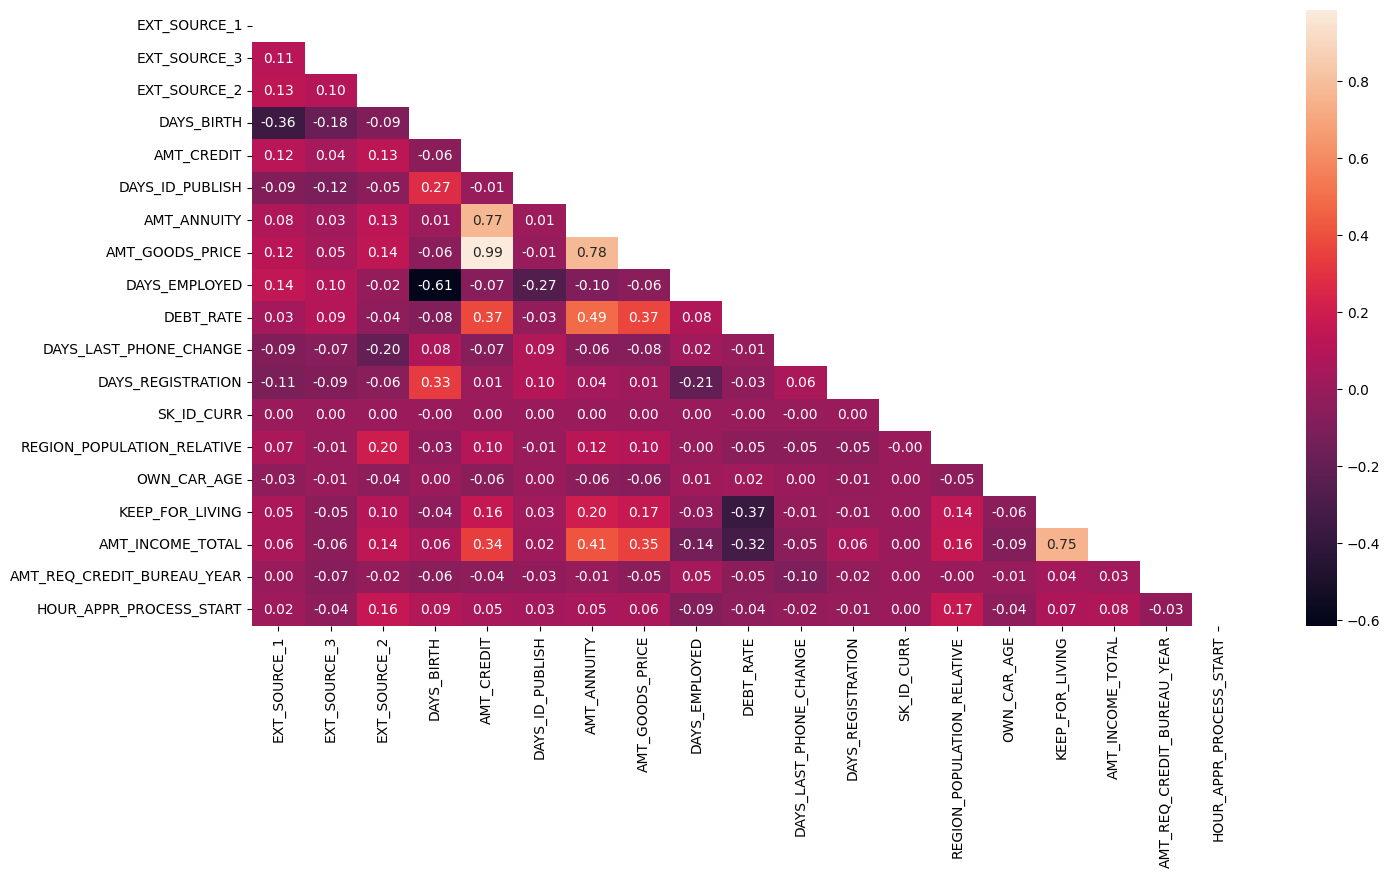

In [16]:
display_info(title="Feature importance sur X_train et les new features", color="DarkRed")
X_train_presonal_feature = X_train.copy()
X_train_presonal_feature = new_features(X_train_presonal_feature)
df_W_personal_feat = feat_importance(X_train_presonal_feature, y=y_train)

In [17]:
def poly_feature_creation(df):
    poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_transformer.fit_transform(df)
    df.columns = df.columns.astype(str)
    poly_feature_names = poly_transformer.get_feature_names_out(input_features=df.columns)
    df_poly = pd.DataFrame(X_poly, columns=poly_feature_names)
    display_info(message="df_poly de polyfeature_creation")
    display(df_poly)
    # df_poly['TARGET'] = app_train['TARGET']

    return df_poly

In [18]:
def get_feat_importanceOnPoly(df_poly):
    importances_lgbm_reordered =getfeatureImportances(df_poly)
    df=feature_selection(importances_lgbm_reordered)
    return df


EXT_SOURCE_1  EXT_SOURCE_3  EXT_SOURCE_2  DAYS_BIRTH  AMT_CREDIT  \
0       1.589111e-15 -6.372508e-16     -0.646817   -0.841308    0.519417   
1      -2.934472e-01 -1.647862e+00      0.639618    0.463433    0.332453   
2      -1.677312e-01  5.560069e-03      0.667931   -0.461456   -0.109410   
3      -3.263536e+00 -1.559498e+00     -0.218215   -0.000959    0.585756   
4       1.589111e-15  5.249847e-01     -0.081859   -0.458935    2.791667   
...              ...           ...           ...         ...         ...   
196801 -6.184661e-01 -6.978752e-01      0.001869    1.752594   -0.817397   
196802  1.589111e-15 -7.273320e-01      0.423767   -0.308415   -0.929077   
196803  1.589111e-15 -6.372508e-16     -1.304998    0.948214   -0.193774   
196804  1.589111e-15  2.833257e-01      1.348495   -0.514607   -0.873237   
196805  2.306745e+00  5.743760e-01     -2.451922   -1.323570   -0.370675   

        DAYS_ID_PUBLISH  AMT_ANNUITY  AMT_GOODS_PRICE  DAYS_EMPLOYED  \
0             -0.157544    -0.230262         0.368835      -0.463846   
1             -0.789022     0.831998         0.381012      -0.472476   
2              0.938921    -0.625046        -0.203478      -0.486959   
3              0.477915     0.909157         0.368835      -0.453125   
4              0.950197     1.613199         2.195365      -0.459594   
...                 ...          ...              ...            ...   
196801         1.295786    -0.937712        -0.727083      -0.455322   
196802         1.368088    -1.076228        -0.848851      -0.491933   
196803        -0.408941    -0.277363        -0.240008      -0.477648   
196804         0.783041    -1.015182        -0.787967      -0.521175   
196805        -1.541225     0.449609        -0.240008       2.137115   

        DEBT_RATE  ...  KEEP_FOR_LIVING^2  KEEP_FOR_LIVING AMT_INCOME_TOTAL  \
0        0.321554  ...           0.024502                         -0.080108   
1       -0.378553  ...           5.156475                          2.116344   
2       -0.217897  ...           0.212520                          0.235928   
3       -0.456223  ...           0.007584                          0.099124   
4        0.726777  ...           0.001101                         -0.010395   
...           ...  ...                ...                               ...   
196801  -1.280284  ...           0.167988                          0.212917   
196802  -1.239793  ...           0.008100                          0.009628   
196803  -0.557541  ...           1.371714                          0.125295   
196804  -0.945068  ...           0.063216                          0.076817   
196805   2.042058  ...           0.554331                          0.534596   

        KEEP_FOR_LIVING AMT_REQ_CREDIT_BUREAU_YEAR  \
0                                     1.997294e-17   
1                                     4.045321e+00   
2                                     5.033184e-01   
3                                     3.553158e-01   
4                                     1.716182e-02   
...                                            ...   
196801                               -4.474877e-01   
196802                                1.603293e-01   
196803                                1.494435e-16   
196804                                2.745093e-01   
196805                               -4.281497e-02   

        KEEP_FOR_LIVING HOUR_APPR_PROCESS_START  AMT_INCOME_TOTAL^2  \
0                                     -0.002881            0.261914   
1                                      0.653919            0.868600   
2                                      0.008484            0.261914   
3                                      0.131801            1.295587   
4                                     -0.040058            0.098114   
...                                         ...                 ...   
196801                                 0.620313            0.269863   
196802                                -0.001656            0.011

fetImport X shape (196806, 209) et y shape (196806,)
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51433
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480


Features  LightGBM Importances  Variance
0                  EXT_SOURCE_1                    90  1.000005
2                  EXT_SOURCE_2                    68  1.000005
1                  EXT_SOURCE_3                    64  1.000005
143             DAYS_EMPLOYED^2                    53  1.000005
7               AMT_GOODS_PRICE                    46  1.000005
..                          ...                   ...       ...
18      HOUR_APPR_PROCESS_START                     3  1.000005
17   AMT_REQ_CREDIT_BUREAU_YEAR                     3  1.000005
126     AMT_ANNUITY OWN_CAR_AGE                     2  1.000005
194               OWN_CAR_AGE^2                     0  1.000005
16             AMT_INCOME_TOTAL                     0  1.000005

[209 rows x 3 columns]

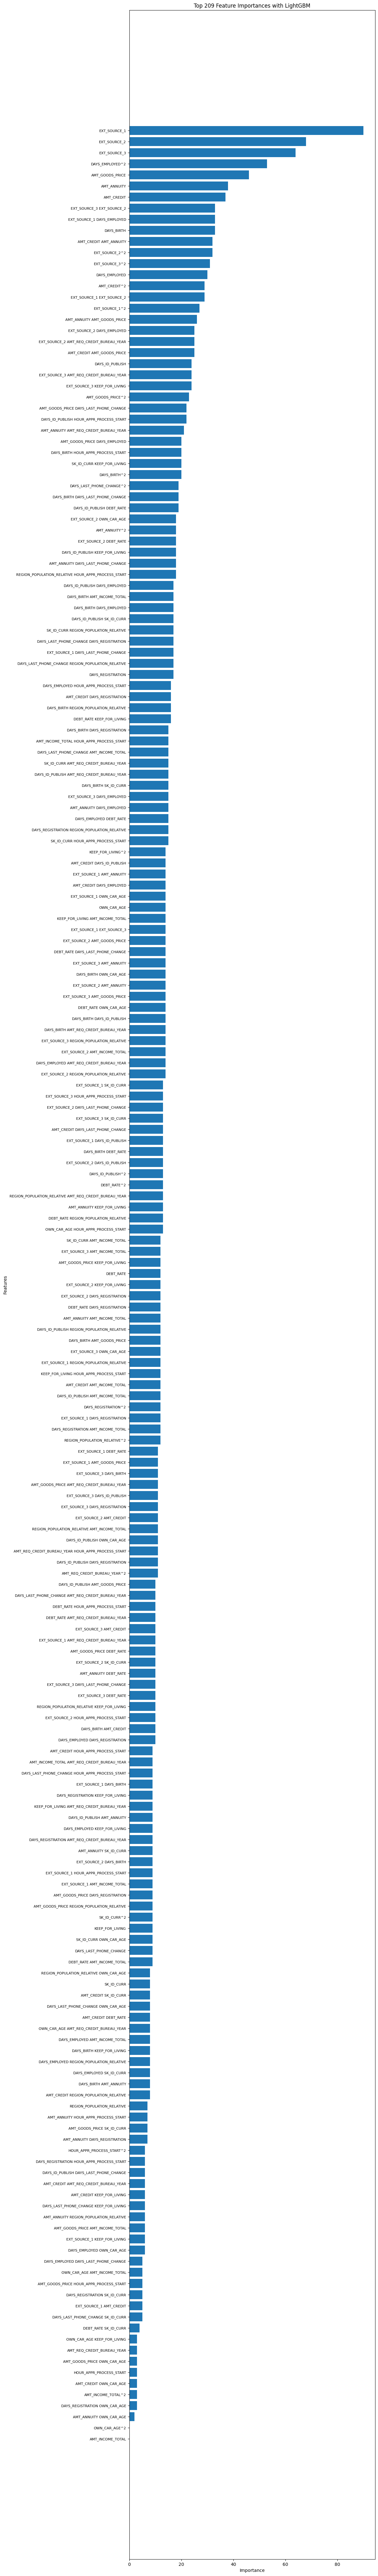

np.int64(90)

Features  LightGBM Importances  Variance  \
0                               EXT_SOURCE_1                    90  1.000005   
2                               EXT_SOURCE_2                    68  1.000005   
1                               EXT_SOURCE_3                    64  1.000005   
143                          DAYS_EMPLOYED^2                    53  1.000005   
7                            AMT_GOODS_PRICE                    46  1.000005   
..                                       ...                   ...       ...   
50   EXT_SOURCE_3 REGION_POPULATION_RELATIVE                    14  1.000005   
49                   EXT_SOURCE_3 SK_ID_CURR                    13  1.000005   
24              EXT_SOURCE_1 DAYS_ID_PUBLISH                    13  1.000005   
79                      DAYS_BIRTH DEBT_RATE                    13  1.000005   
55      EXT_SOURCE_3 HOUR_APPR_PROCESS_START                    13  1.000005   

     Cumulative Importance %  
0                   3.000000  
2                   5.266667  
1                   7.400000  
143                 9.166667  
7                  10.700000  
..                       ...  
50                 62.900000  
49                 63.333333  
24                 63.766667  
79                 64.200000  
55                 64.633333  

[90 rows x 4 columns]

EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED^2  \
0       1.069247e-15     -0.646817  2.295226e-16        -0.470230   
1      -2.934472e-01      0.639618 -1.647862e+00        -0.465389   
2      -1.677312e-01      0.667931  5.560069e-03        -0.457064   
3      -3.263536e+00     -0.218215 -1.559498e+00        -0.476120   
4       1.069247e-15     -0.081859  5.249847e-01        -0.472583   
...              ...           ...           ...              ...   
196801 -6.184661e-01      0.001869 -6.978752e-01        -0.474925   
196802  1.069247e-15      0.423767 -7.273320e-01        -0.454146   
196803  1.069247e-15     -1.304998  2.295226e-16        -0.462445   
196804  1.069247e-15      1.348495  2.833257e-01        -0.436397   
196805  2.306745e+00     -2.451922  5.743760e-01         2.137276   

        AMT_GOODS_PRICE  AMT_ANNUITY  AMT_CREDIT  EXT_SOURCE_1 DAYS_EMPLOYED  \
0              0.368835    -0.230262    0.519417                   -0.163658   
1              0.381012     0.831998    0.332453                   -0.006998   
2             -0.203478    -0.625046   -0.109410                   -0.071368   
3              0.368835     0.909157    0.585756                    1.507261   
4              2.195365     1.613199    2.791667                   -0.163658   
...                 ...          ...         ...                         ...   
196801        -0.727083    -0.937712   -0.817397                    0.154529   
196802        -0.848851    -1.076228   -0.929077                   -0.163658   
196803        -0.240008    -0.277363   -0.193774                   -0.163658   
196804        -0.787967    -1.015182   -0.873237                   -0.163658   
196805        -0.240008     0.449609   -0.370675                    5.406617   

        DAYS_BIRTH  EXT_SOURCE_3 EXT_SOURCE_2  ...  \
0        -0.841308                  -0.094255  ...   
1         0.463433                  -1.130335  ...   
2        -0.461456                  -0.090604  ...   
3        -0.000959                   0.240265  ...   
4        -0.458935                  -0.136499  ...   
...            ...                        ...  ...   
196801    1.752594                  -0.095537  ...   
196802   -0.308415                  -0.397233  ...   
196803    0.948214                  -0.094255  ...   
196804   -0.514607                   0.281312  ...   
196805   -1.323570                  -1.478633  ...   

        AMT_CREDIT DAYS_ID_PUBLISH  DAYS_BIRTH OWN_CAR_AGE   OWN_CAR_AGE  \
0                        -0.074784               -0.003138 -7.994213e-16   
1                        -0.253618               -0.003138 -7.994213e-16   
2                        -0.095490               -0.003138 -7.994213e-16   
3                         0.283685               -0.002005 -1.162521e+00   
4                         2.634708               -0.003138 -7.994213e-16   
...                            ...                     ...           ...   
196801                   -1.043198               -0.003138 -7.994213e-16   
196802                   -1.253151               -0.227709  7.161004e-01   
196803                    0.084818               -0.706007 -7.289928e-01   
196804                   -0.671236                0.756400 -1.451539e+00   
196805                    0.572376                1.755906 -1.307030e+00   

        EXT_SOURCE_2 AMT_GOODS_PRICE  EXT_SOURCE_2 AMT_INCOME_TOTAL  \
0                          -0.394360                       0.188369   
1                           0.108774                       0.449067   
2                          -0.287259                      -0.473340   
3                          -0.229438                      -0.381439   
4                          -0.332956                      -0.162389   
...                              ...                            ...   
196801                     -0.146888                      -0.136218   
196802                     -0.520748                      -0.092589   
196803           

EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED^2  \
0       1.069247e-15     -0.646817  2.295226e-16        -0.470230   
1      -2.934472e-01      0.639618 -1.647862e+00        -0.465389   
2      -1.677312e-01      0.667931  5.560069e-03        -0.457064   
3      -3.263536e+00     -0.218215 -1.559498e+00        -0.476120   
4       1.069247e-15     -0.081859  5.249847e-01        -0.472583   
...              ...           ...           ...              ...   
196801 -6.184661e-01      0.001869 -6.978752e-01        -0.474925   
196802  1.069247e-15      0.423767 -7.273320e-01        -0.454146   
196803  1.069247e-15     -1.304998  2.295226e-16        -0.462445   
196804  1.069247e-15      1.348495  2.833257e-01        -0.436397   
196805  2.306745e+00     -2.451922  5.743760e-01         2.137276   

        AMT_GOODS_PRICE  AMT_ANNUITY  AMT_CREDIT  EXT_SOURCE_1 DAYS_EMPLOYED  \
0              0.368835    -0.230262    0.519417                   -0.163658   
1              0.381012     0.831998    0.332453                   -0.006998   
2             -0.203478    -0.625046   -0.109410                   -0.071368   
3              0.368835     0.909157    0.585756                    1.507261   
4              2.195365     1.613199    2.791667                   -0.163658   
...                 ...          ...         ...                         ...   
196801        -0.727083    -0.937712   -0.817397                    0.154529   
196802        -0.848851    -1.076228   -0.929077                   -0.163658   
196803        -0.240008    -0.277363   -0.193774                   -0.163658   
196804        -0.787967    -1.015182   -0.873237                   -0.163658   
196805        -0.240008     0.449609   -0.370675                    5.406617   

        DAYS_BIRTH  EXT_SOURCE_3 EXT_SOURCE_2  ...  \
0        -0.841308                  -0.094255  ...   
1         0.463433                  -1.130335  ...   
2        -0.461456                  -0.090604  ...   
3        -0.000959                   0.240265  ...   
4        -0.458935                  -0.136499  ...   
...            ...                        ...  ...   
196801    1.752594                  -0.095537  ...   
196802   -0.308415                  -0.397233  ...   
196803    0.948214                  -0.094255  ...   
196804   -0.514607                   0.281312  ...   
196805   -1.323570                  -1.478633  ...   

        AMT_CREDIT DAYS_ID_PUBLISH  DAYS_BIRTH OWN_CAR_AGE   OWN_CAR_AGE  \
0                        -0.074784               -0.003138 -7.994213e-16   
1                        -0.253618               -0.003138 -7.994213e-16   
2                        -0.095490               -0.003138 -7.994213e-16   
3                         0.283685               -0.002005 -1.162521e+00   
4                         2.634708               -0.003138 -7.994213e-16   
...                            ...                     ...           ...   
196801                   -1.043198               -0.003138 -7.994213e-16   
196802                   -1.253151               -0.227709  7.161004e-01   
196803                    0.084818               -0.706007 -7.289928e-01   
196804                   -0.671236                0.756400 -1.451539e+00   
196805                    0.572376                1.755906 -1.307030e+00   

        EXT_SOURCE_2 AMT_GOODS_PRICE  EXT_SOURCE_2 AMT_INCOME_TOTAL  \
0                          -0.394360                       0.188369   
1                           0.108774                       0.449067   
2                          -0.287259                      -0.473340   
3                          -0.229438                      -0.381439   
4                          -0.332956                      -0.162389   
...                              ...                            ...   
196801                     -0.146888                      -0.136218   
196802                     -0.520748                      -0.092589   
196803           

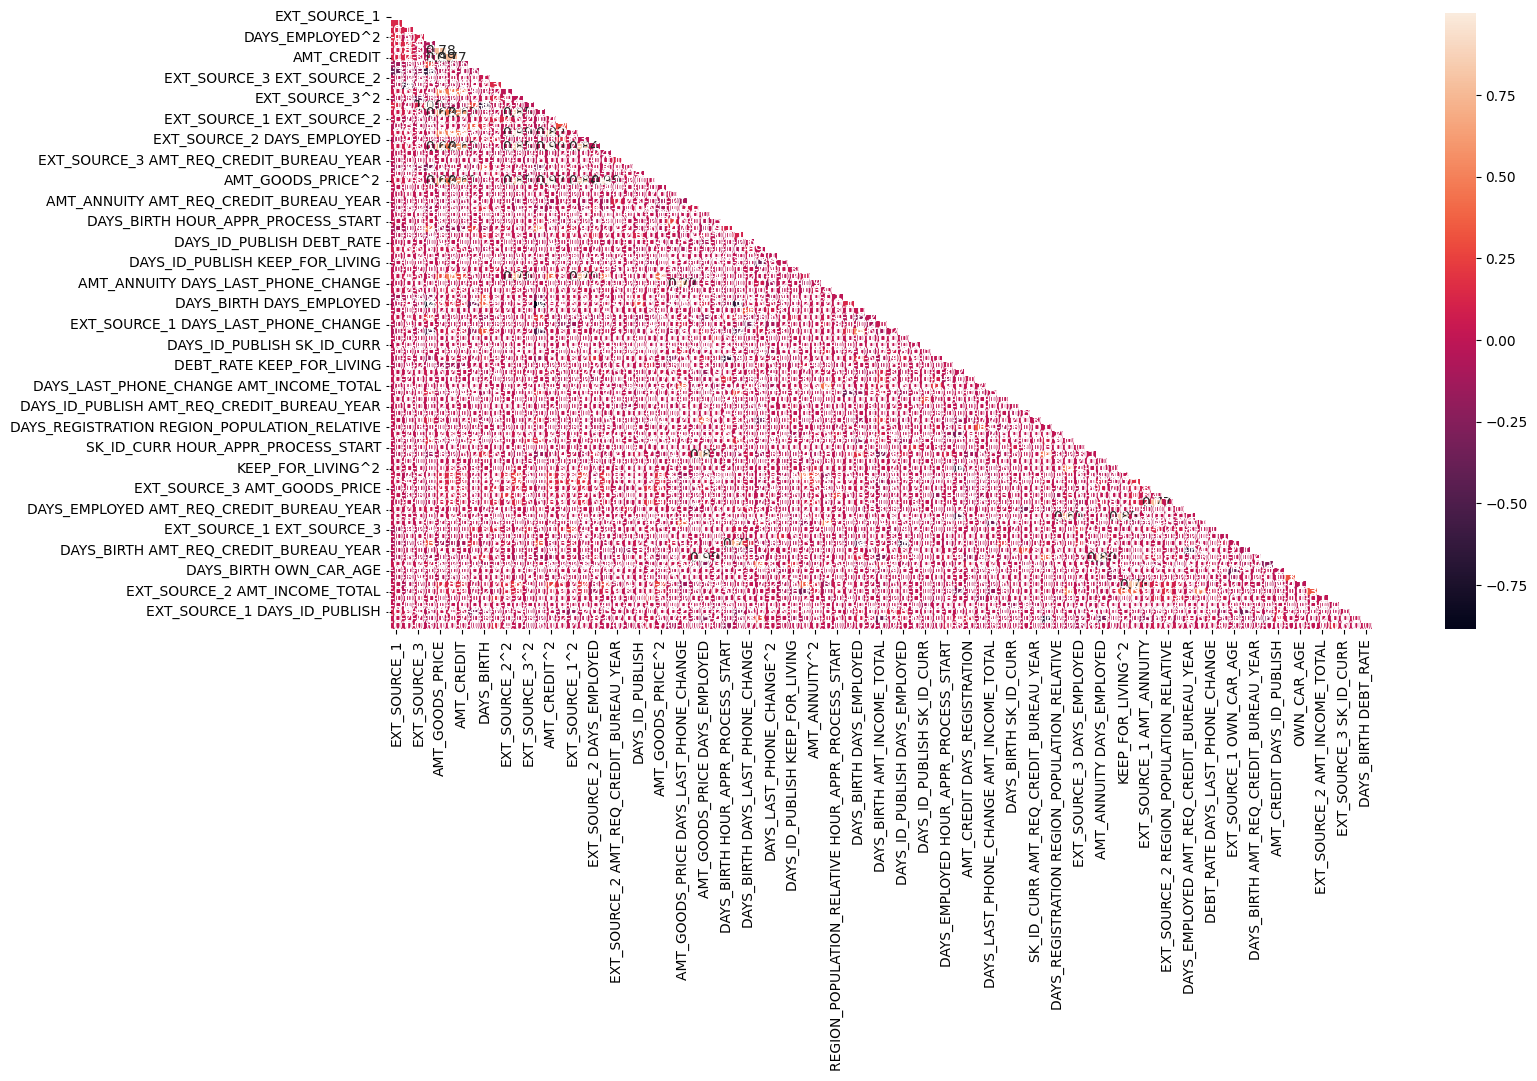

In [19]:
display_info(title="Polynomial feature", color='red', fontsize='30px')

df_poly= poly_feature_creation(df_W_personal_feat)
feat_importance(df_poly,y=y_train)


In [20]:
display_info(message="""En lisant la documentations sklearn, on comprend que le SMOTE est en version expérimental. On utilisera donc imblearn qui en plus est facilement intégrable dans un pipeline""")

In [21]:
display_info(title="PIPELINE", color="red",fontsize="30px")
display_info(message="""La correlation des feature polynomial est moins évidente qu'avec les features original. De plus on conserve avec la selection orginal les features EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3 qui sont considérées comme importantes. </br>
             On garde donc nos features de base sans création de polynomiales""")
display_info(message="""On va realiser notre modelisation en automatisant toute notre logique.</br>
             On va donc utiliser le plus possible les pipeline mis à disposition dans sklearn""")
display_info(message="On commence par séparer nos variable en utilisant make_column_selector")

In [22]:
preprocessor = preprocessing()

models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression( random_state=42),
    'LGBM': LGBMClassifier(random_state=42),
    'XGBOOST': XGBClassifier(random_state=42),
    'DummyClassifier' : DummyClassifier(strategy='most_frequent'),
}


def applyPipeline(model):
    model_pipeline = Pipeline([
            ("preprocessor",preprocessor),
            ("smote",SMOTE(random_state=42)),
            ("classifier",model)
        ])
    return model_pipeline

display_info(message="On doit s'occuper de notre score métier. Pour cela on utilise une fonction metier à l'aide de make_scorer")

def business_cost(y_true,y_pred, cost_FN=10, cost_FP=1):
    
    tn,fp,fn,tp = confusion_matrix(y_true, y_pred).ravel()

    total_cost = (cost_FN*fn) + (cost_FP *fp)

        # Affiche les détails pour le diagnostic
    print(f"FP: {fp}, FN: {fn}, Cost FN: {cost_FN * fn}, Cost FP: {cost_FP * fp}, Total Cost: {total_cost}")


    return -total_cost

business_scorer = make_scorer(business_cost, greater_is_better=False)


scoring = {
    'business_cost': business_scorer,
    'roc_auc': 'roc_auc'
}

# custom_score = make_scorer(custom_metric)
best_model_name = None
best_score = float('inf')
results =[]

for name, model in models.items():
    print(f"Démarrage du test du modèle {name}")
    start_time=time.time()
    with timer(f'Calcul du score pour le model {name}'):
        model_pipeline = applyPipeline(model)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # scores = cross_validate(model_pipeline, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True)
        scores = cross_validate(model_pipeline, df_poly, y_train, cv=kf, scoring=scoring, return_train_score=True)

        elapsed_time = time.time() - start_time
        mean_auc_validation = np.mean(scores['test_roc_auc'])
        mean_business_cost_validation = np.mean(scores['test_business_cost'])

        # mean_score=scores.mean()
        # Affichage des moyennes
        print("Moyenne des scores de validation (AUC):", mean_auc_validation)
        print("Moyenne des scores de validation (Business Cost):", mean_business_cost_validation)

        results.append({
            'Modéle': name,
            'Moyenne AUC': mean_auc_validation,
            'Moyenne Business Cost': mean_business_cost_validation,
            'Temps d\'exécution (s)': elapsed_time
        })

        if mean_business_cost_validation < best_score:  # Comparaison avec le score métier
            best_score = mean_business_cost_validation
            best_model_name = name

results_df = pd.DataFrame(results)

print("\nRésultats des modèles :")
display(results_df)

print("\nMeilleur modèle :", best_model_name)
print("\nScore moyen du meilleur modèle :", best_score)

Démarrage du test du modèle RandomForest
FP: 761, FN: 2884, Cost FN: 28840, Cost FP: 761, Total Cost: 29601
FP: 0, FN: 0, Cost FN: 0, Cost FP: 0, Total Cost: 0
FP: 766, FN: 2899, Cost FN: 28990, Cost FP: 766, Total Cost: 29756
FP: 0, FN: 0, Cost FN: 0, Cost FP: 0, Total Cost: 0
FP: 745, FN: 2919, Cost FN: 29190, Cost FP: 745, Total Cost: 29935
FP: 0, FN: 0, Cost FN: 0, Cost FP: 0, Total Cost: 0
FP: 779, FN: 2922, Cost FN: 29220, Cost FP: 779, Total Cost: 29999
FP: 0, FN: 0, Cost FN: 0, Cost FP: 0, Total Cost: 0
FP: 722, FN: 2935, Cost FN: 29350, Cost FP: 722, Total Cost: 30072
FP: 0, FN: 0, Cost FN: 0, Cost FP: 0, Total Cost: 0
Moyenne des scores de validation (AUC): 0.7009346072092818
Moyenne des scores de validation (Business Cost): 29872.6
Calcul du score pour le model RandomForest - terminé en 2803s
Démarrage du test du modèle LogisticRegression


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 12140, FN: 1084, Cost FN: 10840, Cost FP: 12140, Total Cost: 22980
FP: 47464, FN: 4273, Cost FN: 42730, Cost FP: 47464, Total Cost: 90194


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11875, FN: 1074, Cost FN: 10740, Cost FP: 11875, Total Cost: 22615
FP: 47399, FN: 4273, Cost FN: 42730, Cost FP: 47399, Total Cost: 90129


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11702, FN: 1122, Cost FN: 11220, Cost FP: 11702, Total Cost: 22922
FP: 47107, FN: 4295, Cost FN: 42950, Cost FP: 47107, Total Cost: 90057


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11849, FN: 1092, Cost FN: 10920, Cost FP: 11849, Total Cost: 22769
FP: 47202, FN: 4268, Cost FN: 42680, Cost FP: 47202, Total Cost: 89882


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11764, FN: 1087, Cost FN: 10870, Cost FP: 11764, Total Cost: 22634
FP: 47389, FN: 4292, Cost FN: 42920, Cost FP: 47389, Total Cost: 90309
Moyenne des scores de validation (AUC): 0.7235129420735461
Moyenne des scores de validation (Business Cost): 22784.0
Calcul du score pour le model LogisticRegression - terminé en 34s
Démarrage du test du modèle LGBM
[LightGBM] [Info] Number of positive: 144734, number of negative: 144734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53295
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
FP: 190, FN: 3080, Cost FN: 30800, Cost FP: 190, Total Cost: 30990
FP: 671, FN: 12246, Cost FN: 122460, Cost FP: 671, Total Cost: 123131
[LightGBM] [Info] Number of positive: 144734, number of negat

Modéle  Moyenne AUC  Moyenne Business Cost  \
0        RandomForest     0.700935                29872.6   
1  LogisticRegression     0.723513                22784.0   
2                LGBM     0.722291                30996.6   
3             XGBOOST     0.712043                30506.0   
4     DummyClassifier     0.500000                31776.0   

   Temps d'exécution (s)  
0            2803.169813  
1              33.923550  
2              40.717692  
3              33.451276  
4              12.647020


Meilleur modèle : LogisticRegression

Score moyen du meilleur modèle : 22784.0


In [23]:
display_info(message=f" Notre modèle est trouvé: {best_model_name} </br>On va chercher les meilleurs hyper parametre afin d'améliorer le score de notre modèle")

param_grid = {
    'LGBM': {
       'classifier__num_leaves': [31, 50],
       'classifier__learning_rate': [0.1, 0.05],
       'classifier__n_estimators': [50, 100, 200],
       'classifier__max_depth': [5, 10]
    },
    'RandomForest': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    },
    'LogisticRegression': {
        'classifier__C': [0.01,0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'lbfgs', 'saga']
    },
    'XGBOOST': {
        'classifier__learning_rate': [0.1, 0.05, 0.01],
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [3, 5, 10],
        'classifier__subsample': [0.6, 0.8, 1.0]
    },
    'DummyClassifier': {
        'classifier__strategy': ['most_frequent', 'stratified', 'uniform', 'constant'],
        'classifier__constant': [0, 1] 
    },
    'DummyRegressor': {
        'classifier__strategy': ['mean', 'median', 'quantile'],
        'classifier__quantile': [0.25,0.5,0.75] 
    }
}

model_pipeline = applyPipeline(models[best_model_name])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


if best_model_name in param_grid:
    grid_search = GridSearchCV(model_pipeline,param_grid[best_model_name], cv=kf, scoring=scoring, refit='business_cost')
    grid_search.fit(X_train, y_train)    
    print(f"Meilleurs paramètres pour {best_model_name} :", grid_search.best_params_)
    print(f"Score moyen pour {best_model_name} :", grid_search.best_score_)

    results = pd.DataFrame(grid_search.cv_results_)
    # Pour voir les autres scores
    print("Autres scores :")
    for metric in scoring.keys():
        display(f"{metric} :", grid_search.cv_results_[f'mean_test_{metric}'][grid_search.best_index_])
        display(results[['params', 'mean_test_business_cost', 'mean_test_roc_auc']])


FP: 11155, FN: 1090, Cost FN: 10900, Cost FP: 11155, Total Cost: 22055
FP: 10979, FN: 1086, Cost FN: 10860, Cost FP: 10979, Total Cost: 21839
FP: 10975, FN: 1102, Cost FN: 11020, Cost FP: 10975, Total Cost: 21995
FP: 11010, FN: 1073, Cost FN: 10730, Cost FP: 11010, Total Cost: 21740
FP: 10927, FN: 1088, Cost FN: 10880, Cost FP: 10927, Total Cost: 21807


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11148, FN: 1091, Cost FN: 10910, Cost FP: 11148, Total Cost: 22058


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10973, FN: 1085, Cost FN: 10850, Cost FP: 10973, Total Cost: 21823


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10957, FN: 1103, Cost FN: 11030, Cost FP: 10957, Total Cost: 21987


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11019, FN: 1075, Cost FN: 10750, Cost FP: 11019, Total Cost: 21769


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10937, FN: 1091, Cost FN: 10910, Cost FP: 10937, Total Cost: 21847


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11170, FN: 1095, Cost FN: 10950, Cost FP: 11170, Total Cost: 22120


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 10982, FN: 1090, Cost FN: 10900, Cost FP: 10982, Total Cost: 21882


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 10995, FN: 1109, Cost FN: 11090, Cost FP: 10995, Total Cost: 22085


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11065, FN: 1069, Cost FN: 10690, Cost FP: 11065, Total Cost: 21755


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 10989, FN: 1084, Cost FN: 10840, Cost FP: 10989, Total Cost: 21829
FP: 11169, FN: 1085, Cost FN: 10850, Cost FP: 11169, Total Cost: 22019
FP: 10972, FN: 1086, Cost FN: 10860, Cost FP: 10972, Total Cost: 21832
FP: 10947, FN: 1104, Cost FN: 11040, Cost FP: 10947, Total Cost: 21987
FP: 10986, FN: 1080, Cost FN: 10800, Cost FP: 10986, Total Cost: 21786
FP: 10946, FN: 1096, Cost FN: 10960, Cost FP: 10946, Total Cost: 21906


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11172, FN: 1093, Cost FN: 10930, Cost FP: 11172, Total Cost: 22102


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10999, FN: 1094, Cost FN: 10940, Cost FP: 10999, Total Cost: 21939


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10967, FN: 1093, Cost FN: 10930, Cost FP: 10967, Total Cost: 21897


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11000, FN: 1074, Cost FN: 10740, Cost FP: 11000, Total Cost: 21740


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10940, FN: 1100, Cost FN: 11000, Cost FP: 10940, Total Cost: 21940


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11171, FN: 1091, Cost FN: 10910, Cost FP: 11171, Total Cost: 22081


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 10981, FN: 1089, Cost FN: 10890, Cost FP: 10981, Total Cost: 21871


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11000, FN: 1104, Cost FN: 11040, Cost FP: 11000, Total Cost: 22040


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11065, FN: 1065, Cost FN: 10650, Cost FP: 11065, Total Cost: 21715


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 10982, FN: 1080, Cost FN: 10800, Cost FP: 10982, Total Cost: 21782
FP: 11159, FN: 1086, Cost FN: 10860, Cost FP: 11159, Total Cost: 22019
FP: 10966, FN: 1079, Cost FN: 10790, Cost FP: 10966, Total Cost: 21756
FP: 10932, FN: 1092, Cost FN: 10920, Cost FP: 10932, Total Cost: 21852
FP: 11000, FN: 1079, Cost FN: 10790, Cost FP: 11000, Total Cost: 21790
FP: 10973, FN: 1088, Cost FN: 10880, Cost FP: 10973, Total Cost: 21853


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11174, FN: 1096, Cost FN: 10960, Cost FP: 11174, Total Cost: 22134


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10984, FN: 1092, Cost FN: 10920, Cost FP: 10984, Total Cost: 21904


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10970, FN: 1094, Cost FN: 10940, Cost FP: 10970, Total Cost: 21910


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10987, FN: 1076, Cost FN: 10760, Cost FP: 10987, Total Cost: 21747


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10947, FN: 1097, Cost FN: 10970, Cost FP: 10947, Total Cost: 21917


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11169, FN: 1090, Cost FN: 10900, Cost FP: 11169, Total Cost: 22069


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 10984, FN: 1089, Cost FN: 10890, Cost FP: 10984, Total Cost: 21874


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11001, FN: 1104, Cost FN: 11040, Cost FP: 11001, Total Cost: 22041


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11068, FN: 1064, Cost FN: 10640, Cost FP: 11068, Total Cost: 21708


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 10985, FN: 1082, Cost FN: 10820, Cost FP: 10985, Total Cost: 21805
FP: 11199, FN: 1084, Cost FN: 10840, Cost FP: 11199, Total Cost: 22039
FP: 10969, FN: 1082, Cost FN: 10820, Cost FP: 10969, Total Cost: 21789
FP: 10944, FN: 1094, Cost FN: 10940, Cost FP: 10944, Total Cost: 21884
FP: 11017, FN: 1082, Cost FN: 10820, Cost FP: 11017, Total Cost: 21837
FP: 10977, FN: 1087, Cost FN: 10870, Cost FP: 10977, Total Cost: 21847


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11205, FN: 1094, Cost FN: 10940, Cost FP: 11205, Total Cost: 22145


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11000, FN: 1094, Cost FN: 10940, Cost FP: 11000, Total Cost: 21940


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10933, FN: 1098, Cost FN: 10980, Cost FP: 10933, Total Cost: 21913


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11024, FN: 1075, Cost FN: 10750, Cost FP: 11024, Total Cost: 21774


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10964, FN: 1093, Cost FN: 10930, Cost FP: 10964, Total Cost: 21894


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11171, FN: 1090, Cost FN: 10900, Cost FP: 11171, Total Cost: 22071


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 10983, FN: 1089, Cost FN: 10890, Cost FP: 10983, Total Cost: 21873


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11001, FN: 1104, Cost FN: 11040, Cost FP: 11001, Total Cost: 22041


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11068, FN: 1064, Cost FN: 10640, Cost FP: 11068, Total Cost: 21708


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 10984, FN: 1083, Cost FN: 10830, Cost FP: 10984, Total Cost: 21814
FP: 11207, FN: 1081, Cost FN: 10810, Cost FP: 11207, Total Cost: 22017
FP: 10969, FN: 1080, Cost FN: 10800, Cost FP: 10969, Total Cost: 21769
FP: 10950, FN: 1093, Cost FN: 10930, Cost FP: 10950, Total Cost: 21880
FP: 11020, FN: 1080, Cost FN: 10800, Cost FP: 11020, Total Cost: 21820
FP: 10984, FN: 1089, Cost FN: 10890, Cost FP: 10984, Total Cost: 21874


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 11167, FN: 1094, Cost FN: 10940, Cost FP: 11167, Total Cost: 22107


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10983, FN: 1096, Cost FN: 10960, Cost FP: 10983, Total Cost: 21943


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10962, FN: 1095, Cost FN: 10950, Cost FP: 10962, Total Cost: 21912


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10971, FN: 1081, Cost FN: 10810, Cost FP: 10971, Total Cost: 21781


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


FP: 10955, FN: 1097, Cost FN: 10970, Cost FP: 10955, Total Cost: 21925


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11172, FN: 1090, Cost FN: 10900, Cost FP: 11172, Total Cost: 22072


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 10983, FN: 1089, Cost FN: 10890, Cost FP: 10983, Total Cost: 21873


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11001, FN: 1104, Cost FN: 11040, Cost FP: 11001, Total Cost: 22041


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 11068, FN: 1064, Cost FN: 10640, Cost FP: 11068, Total Cost: 21708


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FP: 10984, FN: 1083, Cost FN: 10830, Cost FP: 10984, Total Cost: 21814
Meilleurs paramètres pour LogisticRegression : {'classifier__C': 0.01, 'classifier__solver': 'saga'}
Score moyen pour LogisticRegression : 21934.2
Autres scores :


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


'business_cost :'

np.float64(21934.2)

params  \
0   {'classifier__C': 0.01, 'classifier__solver': ...   
1   {'classifier__C': 0.01, 'classifier__solver': ...   
2   {'classifier__C': 0.01, 'classifier__solver': ...   
3   {'classifier__C': 0.1, 'classifier__solver': '...   
4   {'classifier__C': 0.1, 'classifier__solver': '...   
5   {'classifier__C': 0.1, 'classifier__solver': '...   
6   {'classifier__C': 1, 'classifier__solver': 'li...   
7   {'classifier__C': 1, 'classifier__solver': 'lb...   
8   {'classifier__C': 1, 'classifier__solver': 'sa...   
9   {'classifier__C': 10, 'classifier__solver': 'l...   
10  {'classifier__C': 10, 'classifier__solver': 'l...   
11  {'classifier__C': 10, 'classifier__solver': 's...   
12  {'classifier__C': 100, 'classifier__solver': '...   
13  {'classifier__C': 100, 'classifier__solver': '...   
14  {'classifier__C': 100, 'classifier__solver': '...   

    mean_test_business_cost  mean_test_roc_auc  
0                   21887.2           0.738061  
1                   21896.8           0.737980  
2                   21934.2           0.737338  
3                   21906.0           0.738208  
4                   21923.6           0.737615  
5                   21897.8           0.737273  
6                   21854.0           0.738606  
7                   21922.4           0.737535  
8                   21899.4           0.737266  
9                   21879.2           0.738699  
10                  21933.2           0.737532  
11                  21901.4           0.737265  
12                  21872.0           0.738695  
13                  21933.6           0.737546  
14                  21901.6           0.737265

'roc_auc :'

np.float64(0.7373384704904477)

params  \
0   {'classifier__C': 0.01, 'classifier__solver': ...   
1   {'classifier__C': 0.01, 'classifier__solver': ...   
2   {'classifier__C': 0.01, 'classifier__solver': ...   
3   {'classifier__C': 0.1, 'classifier__solver': '...   
4   {'classifier__C': 0.1, 'classifier__solver': '...   
5   {'classifier__C': 0.1, 'classifier__solver': '...   
6   {'classifier__C': 1, 'classifier__solver': 'li...   
7   {'classifier__C': 1, 'classifier__solver': 'lb...   
8   {'classifier__C': 1, 'classifier__solver': 'sa...   
9   {'classifier__C': 10, 'classifier__solver': 'l...   
10  {'classifier__C': 10, 'classifier__solver': 'l...   
11  {'classifier__C': 10, 'classifier__solver': 's...   
12  {'classifier__C': 100, 'classifier__solver': '...   
13  {'classifier__C': 100, 'classifier__solver': '...   
14  {'classifier__C': 100, 'classifier__solver': '...   

    mean_test_business_cost  mean_test_roc_auc  
0                   21887.2           0.738061  
1                   21896.8           0.737980  
2                   21934.2           0.737338  
3                   21906.0           0.738208  
4                   21923.6           0.737615  
5                   21897.8           0.737273  
6                   21854.0           0.738606  
7                   21922.4           0.737535  
8                   21899.4           0.737266  
9                   21879.2           0.738699  
10                  21933.2           0.737532  
11                  21901.4           0.737265  
12                  21872.0           0.738695  
13                  21933.6           0.737546  
14                  21901.6           0.737265

In [24]:
print(f"Meilleurs paramètres pour {best_model_name} :", grid_search.best_params_)
print(f"Score moyen pour {best_model_name} :", grid_search.best_score_)
best_roc_auc = grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_]
print("\nROC AUC du meilleur modèle :", best_roc_auc)

Meilleurs paramètres pour LogisticRegression : {'classifier__C': 0.01, 'classifier__solver': 'saga'}
Score moyen pour LogisticRegression : 21934.2

ROC AUC du meilleur modèle : 0.7373384704904477


In [25]:
best_model = models[best_model_name]
best_model_params = grid_search.best_params_
best_model_params_cleaned = {key.replace('classifier__',''): value for key, value in best_model_params.items()}
best_model = best_model.set_params(**best_model_params_cleaned)
best_model

LogisticRegression(C=0.01, random_state=42, solver='saga')

In [26]:
display_info(title="On fit notre model avec les paramètres définis précédement avec notre jeu de données", color="red")

best_model_pipeline = applyPipeline(best_model)
preprocessor = preprocessing()

best_model_pipeline.fit(df_poly, y_train)

/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x43a8b5710>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x43a8afbd0>)])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(C=0.01, random_state=42, solver='saga'))])

In [27]:
def plot_roc_curve(best_model_pipeline, df, y_df,title):
    y_pred_prob = best_model_pipeline.predict_proba(df)[:,1]

    fpr, tpr, thresholds = roc_curve(y_df, y_pred_prob)
    roc_auc = roc_auc_score(y_df, y_pred_prob)
    # 3. Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')

    # 4. Plot the diagonal (random model) line
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Model')

    # 5. Add labels and title
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {title}')
    plt.legend(loc='lower right')

    # 6. Show the plot
    plt.grid(True)
    plt.show()


In [28]:
df_poly.shape

(196806, 209)

In [29]:
display_info(message="On peux tracer la learning curve ")
best_params = grid_search.best_params_
model_pipeline.set_params(**best_params)
def learningCurve(model_pipeline,X,y):
    N,train_score, val_score=learning_curve(model_pipeline, X, y, train_sizes=np.linspace(0.1,1.0,10),cv=5)

    print(N)
    plt.plot(N, train_score.mean(axis=1), label ='train')
    plt.plot(N, val_score.mean(axis=1), label ='validation')
    plt.xlabel('train_sizes')
    plt.legend()

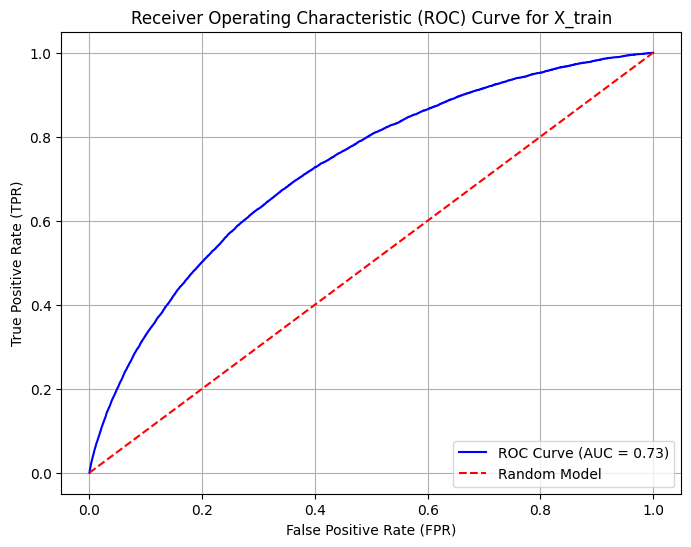

/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/pytho

[ 15744  31488  47233  62977  78722  94466 110210 125955 141699 157444]


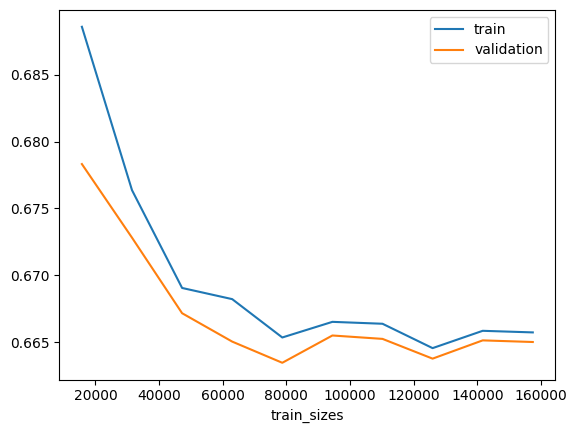

In [30]:
display_info(title="ROC Curve pour X_train", color="red")

plot_roc_curve(best_model_pipeline, df_poly, y_train, title="X_train")
display_info(message="Learning curve avec X_train")
learningCurve(model_pipeline=model_pipeline,X=df_poly, y=y_train)

In [31]:
def apply_Mod_On_NewDf(df):
    X_test_presonal_feature = df.copy()
    X_test_presonal_feature= new_features(X_test_presonal_feature)

    X_test_new_feat_col = df_W_personal_feat.columns.intersection(X_test_presonal_feature.columns)
    X_test_presonal_feature = X_test_presonal_feature[X_test_new_feat_col]

    preprocessor=preprocessing()
    X_test_presonal_feature = preprocessor.fit_transform(X_test_presonal_feature)

    # Récupérer les noms des colonnes et les simplifier
    feature_names = preprocessor.get_feature_names_out()
    feature_names = [name.split('__')[-1] for name in feature_names]
    X_test_presonal_feature = pd.DataFrame(X_test_presonal_feature, columns=feature_names)
    df_poly_test= poly_feature_creation(X_test_presonal_feature)

    return df_poly_test

EXT_SOURCE_1  EXT_SOURCE_3  EXT_SOURCE_2  DAYS_BIRTH  AMT_CREDIT  \
0         -1.197709      0.000000      0.727939    1.109869    0.983478   
1          0.000000     -0.116581      0.619245   -0.835774   -0.371398   
2          1.122878      1.496692      1.174263   -1.561401    0.188468   
3          0.000000     -0.342313      1.451008   -1.918014   -0.984116   
4          0.000000     -1.520562      0.026940    1.626074   -0.783819   
...             ...           ...           ...         ...         ...   
49197     -2.287520      0.037901     -0.737549    0.711004   -0.371398   
49198      0.000000     -0.065078     -1.316876   -1.418802   -0.293823   
49199     -1.447958     -1.245917      0.442661   -0.903285    0.241095   
49200      0.000000      1.553692      0.543024   -1.610312   -0.315412   
49201      0.101024      1.065432     -0.052706    0.288028    0.137453   

       DAYS_ID_PUBLISH  AMT_ANNUITY  AMT_GOODS_PRICE  DAYS_EMPLOYED  \
0             1.087843     0.212113         1.236064      -0.450629   
1            -0.127867    -0.314915        -0.239835       2.142607   
2            -0.914075     0.813545         0.370041       2.142607   
3            -0.818115    -1.050274        -0.971685       2.142607   
4             0.905850    -0.025050        -0.727735      -0.453717   
...                ...          ...              ...            ...   
49197         0.504143     1.003895        -0.239835      -0.462675   
49198        -1.512995    -0.161147        -0.483785       2.142607   
49199        -0.345596     0.451136         0.065103      -0.471611   
49200        -0.959076    -0.913247        -0.178847       2.142607   
49201        -1.064301     0.054315         0.126091      -0.460403   

       DEBT_RATE  ...  KEEP_FOR_LIVING^2  KEEP_FOR_LIVING AMT_INCOME_TOTAL  \
0       2.015648  ...           0.082187                          0.048076   
1      -0.148572  ...           0.014849                          0.008167   
2       4.161151  ...           0.119796                          0.066754   
3      -0.796575  ...           0.023555                          0.016724   
4       0.281608  ...           0.015057                         -0.009666   
...          ...  ...                ...                               ...   
49197   0.045295  ...           0.004567                          0.006811   
49198   0.025501  ...           0.027883                         -0.011191   
49199   0.905921  ...           0.030852                          0.014719   
49200   0.251516  ...           0.077898                          0.053830   
49201   0.703967  ...           0.038550                          0.021395   

       KEEP_FOR_LIVING AMT_REQ_CREDIT_BUREAU_YEAR  \
0                                   -3.688363e-17   
1                                    1.332766e-01   
2                                    1.780037e-01   
3                                   -9.995673e-03   
4                                   -1.342077e-01   
...                                           ...   
49197                                4.401595e-03   
49198                                2.043815e-01   
49199                               -2.149875e-01   
49200                               -1.817768e-02   
49201                                1.009764e-01   

       KEEP_FOR_LIVING HOUR_APPR_PROCESS_START  AMT_INCOME_TOTAL^2  \
0                                     0.005909            0.028122   
1                                    -0.109464            0.004492   
2                                    -0.734979            0.037198   
3                                    -0.090856            0.011874   
4                                     0.072643            0.006205   
...                                        ...                 ...   
49197                                 0.081410            0.010156   
49198                                -0.105737            0.004492   
49199                                 0.218827   

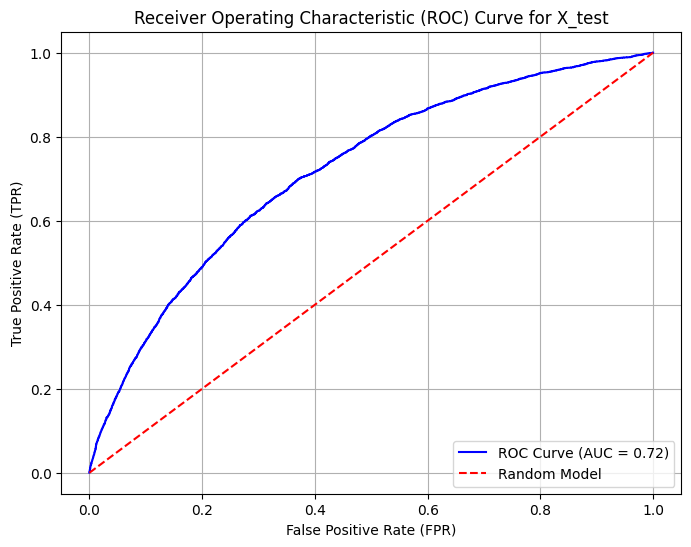

/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/pytho

[ 3936  7872 11808 15744 19680 23616 27552 31488 35424 39361]


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


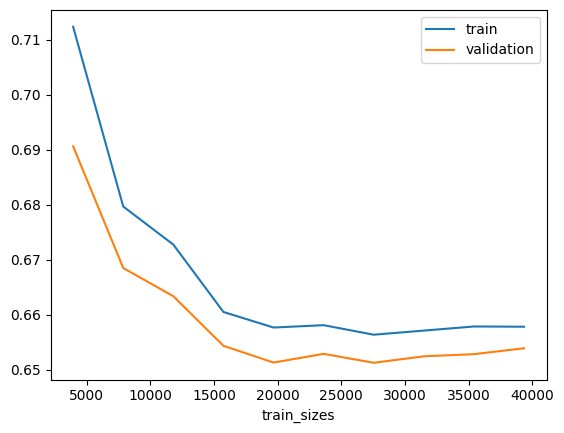

In [32]:
display_info(title="ROC Curve pour X_test", color="red")

df_poly_test=apply_Mod_On_NewDf(X_test)
plot_roc_curve(best_model_pipeline, df_poly_test,y_test, title="X_test")
display_info(message="Learning curve avec X_test")
learningCurve(model_pipeline=model_pipeline,X=df_poly_test, y=y_test)


EXT_SOURCE_1  EXT_SOURCE_3  EXT_SOURCE_2  DAYS_BIRTH  AMT_CREDIT  \
0          0.000000     -0.475568      0.417515    0.586244    0.429626   
1          0.647698     -0.148345      0.550224   -0.379112   -0.579960   
2          0.000000      0.160668     -2.542752   -1.861828   -0.780424   
3          0.901734     -0.566015     -0.509750    1.468960    0.943686   
4          0.000000      0.474507     -0.837493   -0.325087   -0.683812   
...             ...           ...           ...         ...         ...   
61498      0.000000     -0.714390      0.446661   -1.107765    0.588402   
61499      0.980854     -2.374828      1.028889   -0.394450    1.761246   
61500     -0.214426     -1.126310      0.630954    0.617606   -0.891370   
61501     -0.108317     -1.017984     -1.024252    1.076591    0.752647   
61502      0.000000     -0.925273      0.021104   -0.156831   -0.839595   

       DAYS_ID_PUBLISH  AMT_ANNUITY  AMT_GOODS_PRICE  DAYS_EMPLOYED  \
0            -0.929627     0.247908         0.409926      -0.456583   
1             1.146132    -0.499468        -0.603151      -0.490551   
2             0.343699    -0.588628        -0.847266      -0.464228   
3             0.465880     0.772229         0.910361      -0.458343   
4             1.290768    -0.517926        -0.700797      -0.465460   
...                ...          ...              ...            ...   
61498        -0.630448     0.040495         0.495366       2.115466   
61499         1.102543     0.767849         2.082113      -0.464207   
61500         0.118489    -0.003616        -0.847266      -0.464249   
61501        -0.658187     1.310002         0.983596      -0.463489   
61502         1.778833     0.075533        -0.847266      -0.464348   

       DEBT_RATE  ...  KEEP_FOR_LIVING^2  KEEP_FOR_LIVING AMT_INCOME_TOTAL  \
0       0.145527  ...           0.264584                          0.050175   
1       0.427067  ...           0.381496                          0.427389   
2      -0.586388  ...           0.036526                          0.033789   
3       0.234449  ...           1.042706                          0.175555   
4      -0.758942  ...           0.000695                          0.002653   
...          ...  ...                ...                               ...   
61498  -0.106392  ...           0.638222                         -0.046269   
61499   0.327418  ...           0.011148                         -0.010621   
61500  -1.119079  ...           0.217183                          0.785581   
61501  -0.474162  ...           9.257553                          4.526069   
61502  -0.588772  ...           0.032949                         -0.090190   

       KEEP_FOR_LIVING AMT_REQ_CREDIT_BUREAU_YEAR  \
0                                       -0.026559   
1                                       -1.449141   
2                                       -0.119501   
3                                       -0.533040   
4                                       -0.013766   
...                                           ...   
61498                                   -0.875303   
61499                                    0.055117   
61500                                   -0.243271   
61501                                    0.157100   
61502                                    0.094754   

       KEEP_FOR_LIVING HOUR_APPR_PROCESS_START  AMT_INCOME_TOTAL^2  \
0                                    -0.774729            0.009515   
1                                     0.013407            0.478804   
2                                     0.471349            0.031258   
3                                     0.601890            0.029557   
4                                     0.007486            0.010119   
...                                        ...                 ...   
61498                                -0.261459            0.003354   
61499                                 0.002292            0.010119   
61500                                -0.294926   

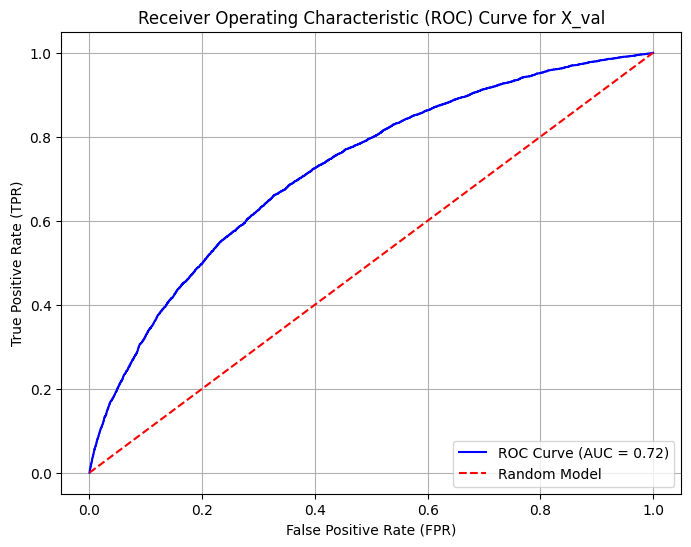

/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/pytho

[ 4920  9840 14760 19680 24601 29521 34441 39361 44281 49202]


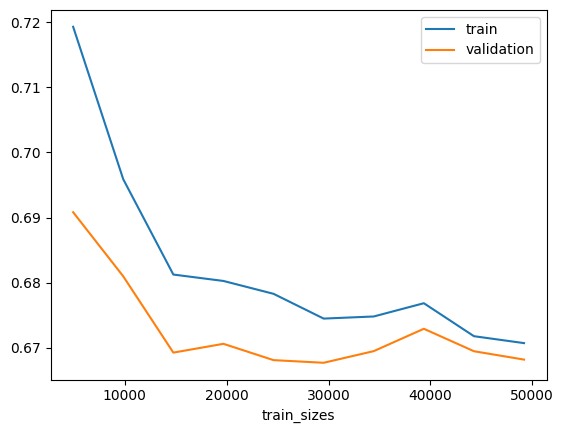

In [33]:
display_info(title="ROC Curve pour X_val", color="red")
y_val = X_val['TARGET']
Xval=X_val.drop('TARGET', axis=1)
df_poly_val=apply_Mod_On_NewDf(Xval)
plot_roc_curve(best_model_pipeline, df_poly_val,y_val, title="X_val")
display_info(message="Learning curve avec X_Val")
learningCurve(model_pipeline=model_pipeline,X=df_poly_val, y=y_val)


In [34]:
display_info(title="Shape", color='Red')

# plot_roc_curve(best_model_pipeline, X_val_test, y_val_test)

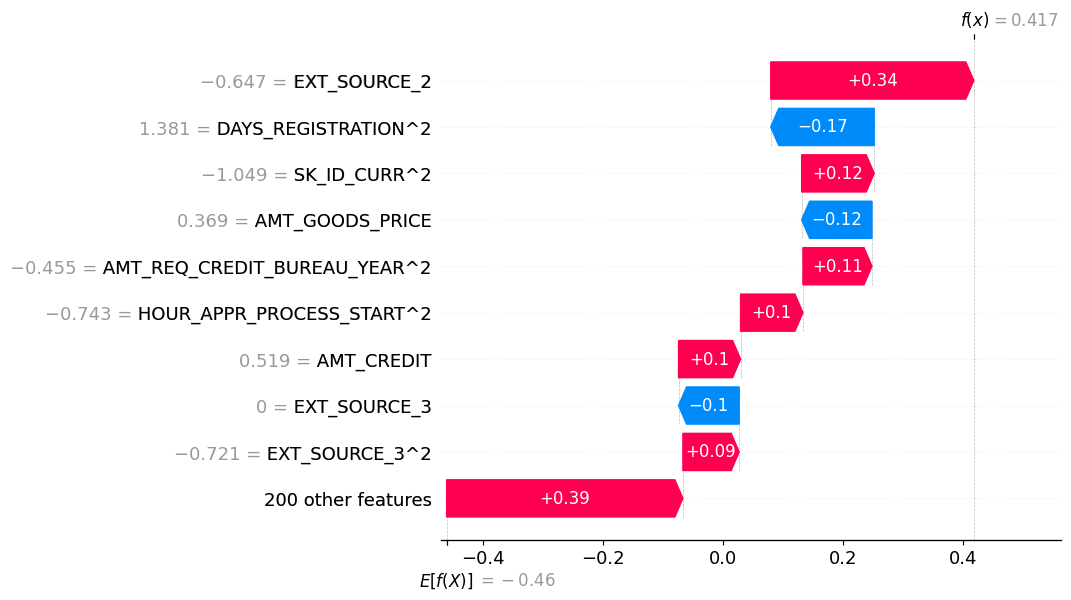

In [35]:
shap.initjs()

# best_model_pipeline.fit(X_train, y_train)
X_test_transformed = best_model_pipeline.named_steps['preprocessor'].transform(df_poly)
explainer = shap.Explainer(best_model_pipeline.named_steps['classifier'], X_test_transformed,feature_names=df_poly.columns)
shap_values = explainer(X_test_transformed)

shap.plots.waterfall(shap_values[0])

# Afficher le force plot interactif
force_plot=shap.force_plot(explainer.expected_value, shap_values[0].values, X_test_transformed[0], feature_names=df_poly.columns)
HTML(f"<div style='background-color:Lavender;'>{shap.getjs() + force_plot.html()}</div>")
